In [9]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))



In [10]:
#read the file
df = pd.read_csv('Data Extraction/KNCUSDT-1h-binance.csv')
df['close'] = np.log(df['close'])

In [11]:
df['Date'] = df['timestamp']

In [12]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])

#creating dataframe with date and the target variable
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

# splitting into train and validation
train = new_data[:10000]
valid = new_data[10000:]


In [13]:
len(valid)

2500

In [14]:
# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['close'][len(train)-2500+i:].sum() + sum(preds)
    b = a/2500
    preds.append(b)


In [15]:

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
0.13016767084406627


In [16]:
#Linear Regression
from fastai.tabular.all import *
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp





In [17]:
train = new_data[:10000]
valid = new_data[10000:]
x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [18]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.3535836120198892

In [19]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [20]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [21]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.4614008706758339

from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:10000]
valid = data[10000:]

training = train['close']
validation = valid['close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=2500)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-np.array(forecast['Prediction'])),2)))
rms

from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:10000]
valid = new_data[10000:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [50]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:10000,:]
valid = dataset[10000:,:]

#converting dataset into x_train and y_train
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(train)
scaled_data = train
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train).astype('float32'), np.array(y_train).astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [71]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=60))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=1)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_18/strided_slice:0) to a numpy array.

In [ ]:
#predicting 2500 values, using past 60 from the train data
inputs = new_data.iloc[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
#inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#closing_price = scaler.inverse_transform(closing_price)
#closing_price = []
#for i in range(len(X_test)):
#    closing_price.append(scaler.inverse_transform(model.predict(X_test[i:i+1])))


In [ ]:
closing_price = model.predict(X_test)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
closing_price = np.array(closing_price).reshape(-1,1)

In [69]:
plt.figure(figsize=(12, 7.5))
plt.plot(closing_price,label='Prediction')
plt.plot(valid,label='Actual')
plt.legend(fontsize = 15)
plt.ylabel('PnL (USD)',fontsize=16)
plt.xlabel('Hour',fontsize=16)
plt.title('Evolution of predicted log price of price through time',fontsize=18)
plt.show()

NameError: name 'closing_price' is not defined

<Figure size 864x540 with 0 Axes>

In [ ]:

dff = pd.DataFrame(closing_price)  

In [ ]:
dff['closing_price'] = closing_price

In [ ]:
dff['valid'] = valid
dff

In [ ]:
Has_KNC = False
pnl = []
pnl.append(1000)
money = 1000
for k in range(1,len(dff)):
    if dff.iloc[k]['closing_price'] > dff.iloc[k-1]['valid'] and not Has_KNC:
        share = money/dff.iloc[k-1]['valid']
        Has_KNC = True
        
    if dff.iloc[k]['closing_price'] < dff.iloc[k-1]['valid'] and Has_KNC:
        money = share* dff.iloc[k-1]['valid']
        Has_KNC = False
    if Has_KNC:
        pnl.append(share * dff.iloc[k-1]['valid'])
    else:
        pnl.append(money)

        


In [ ]:
pnl[-1]

In [ ]:
original = valid*1000/valid[0]

plt.figure(figsize=(12, 7.5))
plt.plot(original,label='baseline')
plt.plot(pnl,label = 'LSTM Strategy')
plt.legend(fontsize = 15)
plt.ylabel('PnL (USD)',fontsize=16)
plt.xlabel('Hour',fontsize=16)
plt.title('The evolution of PNL for strategy compared with baseline',fontsize=18)
plt.show()







In [17]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import matplotlib.pyplot as plt

import torch
import torchvision
from torch.backends import cudnn
import torch.optim as optim
import numpy as np
import time
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate
from scipy.stats import entropy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
x_train, y_train = [], []
for i in range(5,len(train)):
    x_train.append(scaled_data[i-5:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train).astype('float32'), np.array(y_train).astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [66]:
inputs = new_data.iloc[len(new_data) - len(valid) - 5:].values
inputs = inputs.reshape(-1,1)
#inputs  = scaler.transform(inputs)

X_test = []
for i in range(5,inputs.shape[0]):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [48]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1]))
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test.astype('float32'))

In [108]:
@variational_estimator
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.bfc1 = BayesianLinear(input_dim, 512)
        self.bfc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Flatten image
        #x = x.view(-1,28*28)
        x = self.bfc1(x)
        x = F.relu(x)
        x = self.bfc3(x)


        return x

In [113]:
# Train the model and create model
def train_model(epochs,l):
    # l is the coefficient of regularization
    optimizer = torch.optim.Adam(BNNmodel.parameters(), lr=0.5,weight_decay=l)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        #all the samples are used for training 
        
        yhat= BNNmodel(x_train)
        loss= criterion(yhat,y_train)
        #store the loss for both the training and validation data for both models 
        LOSS.append(loss.item())
        #model_drop.eval()
        BNNmodel.train()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [114]:
LOSS = []
BNNmodel = BayesianMLP(5, 1)
epochs = 1000
l = 0.00005
train_model(epochs,l)

In [115]:
#BNNmodel.train()
yhat = BNNmodel(x_train)

diff = (yhat-y_train.reshape(-1,1))**2
sum(diff.detach().numpy()/9499)

2.6959567

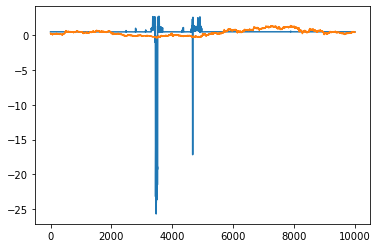

In [116]:
plt.plot(yhat.detach().numpy())
plt.plot(y_train.detach().numpy())

In [94]:
yhat = []
for j in range(100):
    yhat.append(BNNmodel(x_train).detach().numpy())

In [95]:
mu = np.mean(yhat,axis = 0)
std = np.std(yhat,axis = 0)

In [74]:
sum((mu-y_train.detach().numpy())**2)

17062134.0